## Starting with Michael Wood-Vasey's notebook as a starting point
## Craig Lage - 11Jan19

## Make a brighter-fatter kernel from a set of high-intensity flats measured at UC Davis.


In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


lsst_distrib          16.0-2-g3466de9+2 	current d_2018_11_25 d_2018_11_26 w_2018_47 setup


This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions above. Also bringing in cp_pipe, to allow me to make changes to makeBrighterFatterKernel.py.

In [2]:
import eups
assert eups.getSetupVersion("obs_base")
assert eups.getSetupVersion("obs_lsst")
assert eups.getSetupVersion("cp_pipe")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from astropy.io import fits
import os, time, datetime

# LSST stack imports
from lsst.daf.persistence import Butler
from lsst.ip.isr.assembleCcdTask import AssembleCcdTask, AssembleCcdConfig
from lsst.geom import Point2I, Extent2I, Box2I
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask

In [4]:
#This ingests the fits files using the modified code in obs_lsst
E2V_REPO_DIR = '/home/cslage/Research/LSST/code/notebooks/notebooks_2018_47/repo5_e2v'
E2V_FITS_DIR = '/mnt/storm-lsst/GUI/20181205_e2v_flats/'
! rm -rf /home/cslage/Research/LSST/code/notebooks/notebooks_2018_47/repo5_e2v
! mkdir /home/cslage/Research/LSST/code/notebooks/notebooks_2018_47/repo5_e2v
! echo "lsst.obs.lsst.ucd.UcdMapper" > /home/cslage/Research/LSST/code/notebooks/notebooks_2018_47/repo5_e2v/_mapper

fitsFileList = []
for f in os.listdir(E2V_FITS_DIR):
    try:
        fits_file = fits.open(os.path.join(E2V_FITS_DIR, f))
    except:
        continue
    #seqnum = int(fits_file[0].header['SEQNUM'])
    #if seqnum == 100 or (seqnum % 40 == 0 and seqnum < 275):
    fitsFileList.append(os.path.join(E2V_FITS_DIR, f))
print(fitsFileList)
args = E2V_REPO_DIR
for fitsFile in fitsFileList:
    args += " "
    args += fitsFile

# Ingest the  target image
! ingestImages.py {args}

['/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_133_20181205153909.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_181_20181205155135.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_268_20181205161851.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_179_20181205155102.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_183_20181205155208.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_156_20181205154451.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_187_20181205155315.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_126_20181205153730.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_195_20181205155531.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_flat_flat_276_20181205162141.fits', '/mnt/storm-lsst/GUI/20181205_e2v_flats/E2V-CCD250-112-04_f

In [5]:
# Now just pick out 5 pairs from the ingesed fits files
butler = Butler(E2V_REPO_DIR)
visits = []
my_metaData = butler.queryMetadata('raw', ['visit', 'dateObs'])
for item in my_metaData:
    dateObs = datetime.datetime.strptime(item[1],"%Y-%m-%dT%H:%M:%S.%f")
    if dateObs.year == 2018 and dateObs.month == 12 and (dateObs.day == 5 or dateObs.day == 6):
        visits.append(item[0])
print(len(visits))
pairs = []
for i in range(0,len(visits),2):
    if i%40 == 0:
        pairs.append('%s,%s'%(str(visits[i]),str(visits[i+1])))
print(len(pairs))
print(pairs)

200
5
['281719908,281719920', '281720457,281720472', '281721087,281721104', '281721790,281721809', '281722577,281722597']


In [6]:
# This tests whether the changes to be able to use dataRef.put
# to save the means and xcorrs is working yet.  It isn't.
print(butler._repos.outputs()[0].repo.map('brighterFatterGain', {}, write=True))
print(butler._repos.outputs()[0].repo.map('brighterFatterMeans', {}, write=True))

builtins.dict at PickleStorage(calibrations/bfGain-000.pkl)


TypeError: sequence item 0: expected str instance, NoneType found

In [7]:
# Now create the BF kernel
args = [str(E2V_REPO_DIR), '--rerun', 'test','--id', 'detector=0','--visit-pairs']
for pair in pairs:
    args.append(str(pair))

args = args + ['-c','xcorrCheckRejectLevel=2', 'doCalcGains=True', 'level="AMP"', '--clobber-config',
               '--clobber-versions']

command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

corr_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py /home/cslage/Research/LSST/code/notebooks/notebooks_2018_47/repo5_e2v --rerun test --id detector=0 --visit-pairs 281719908,281719920 281720457,281720472 281721087,281721104 281721790,281721809 281722577,281722597 -c xcorrCheckRejectLevel=2 doCalcGains=True level="AMP" --clobber-config --clobber-versions
Starting BF kernel task - 10-Jan-19
Running pair  281719908 281719920
Running pair  281720457 281720472
Running pair  281721087 281721104
Running pair  281721790 281721809
Running pair  281722577 281722597
In calculateAndApplyGains
Doing Amp  C17
Doing Amp  C17 [ 1.68394593e-11 -2.61078687e-06  2.27091233e-01  1.52772029e+00]
Doing Amp  C17 Gain =  4.40351653359992
Doing Amp  C16
Doing Amp  C16 [ 3.29726113e-12 -2.16578403e-06  2.28075883e-01  6.64230126e+00]
Doing Amp  C16 Gain =  4.384505668758856
Doing Amp  C15
Doing Amp  C15 [ 2.47776686e-12 -2.14277484e-06  2.20219820e-01  7.20937985e+00]
Doing Amp  C15 Gain =  4.54091735200734
Doing Amp  C14
Doing Amp  

In [9]:
# This checks whether we have successfully pickled the means and xcorrs.
# This is just a stop-gap until I get the datRef.put issue fixed.
import pickle as pkl
filename =E2V_REPO_DIR+'/corr_data_0_full.pkl'
with open(filename, 'rb') as f:
    xcorr_pickle= pkl.load(f)

print(xcorr_pickle.keys())
means = xcorr_pickle['means']
print(means['C13'])
xcorrs = xcorr_pickle['xcorrs']
print(xcorrs['C13'][1])

dict_keys(['xcorrs', 'means'])
[[1508.8358797203812, 1504.3690079415617], [7412.026390082666, 7406.783094068472], [13319.286628492137, 13314.296090415022], [19223.266026359237, 19217.261117601778], [25112.77917950243, 25106.925567967523]]
[[ 3.07272315e+03  4.08710509e+01  6.02132884e+00 -2.56363476e+00
  -5.23397096e+00 -7.68367735e-01 -2.90744038e+00  1.99259646e-01
  -3.25897588e+00]
 [ 1.76481595e+01  8.93577599e+00  6.36025157e+00 -2.84634104e+00
   3.68177896e+00  4.48769646e+00  1.50982676e+00 -4.64210592e-01
   4.11365908e+00]
 [ 2.61709059e+00  9.44904420e-02 -1.89194101e-01  3.82413375e+00
  -4.19340171e+00  3.83986083e+00  6.80866211e-01 -1.28270089e+00
   4.09198922e+00]
 [-1.23288930e+00  4.04630565e+00  3.31877868e+00  1.91890659e+00
   3.09498846e+00  1.45730324e-01  1.91134134e+00  9.84362130e-01
  -1.69073175e+00]
 [-3.05670396e+00 -6.45749889e-01  2.28608138e+00 -4.77877458e-01
  -5.92080460e+00 -3.69358092e+00 -3.29547533e+00 -5.34701830e+00
   4.22203109e+00]
 [ 3.0

In [10]:
print(butler.queryMetadata('raw', [ 'detector', 'detectorName', 'raftName'])[0])

(0, 'S00', 'RTM-999')


In [11]:
# Check that the gains were stored.
bfk_butler = Butler(E2V_REPO_DIR+'/rerun/test')
gains = bfk_butler.get('brighterFatterGain', dataId={'raftName': 'RTM-999', 'detectorName': 'S00',
                                                              'detector': 0})
print(gains)

{'C17': 4.40351653359992, 'C16': 4.384505668758856, 'C15': 4.54091735200734, 'C14': 4.499682676952042, 'C13': 4.505361717098738, 'C12': 4.423854851208871, 'C11': 4.4758850352304025, 'C10': 4.632477044718516, 'C00': 4.5965365758834675, 'C01': 4.649355016473286, 'C02': 4.6118568412361896, 'C03': 4.421521084301513, 'C04': 3.1501890502549017, 'C05': 3.128138057766932, 'C06': 3.0642988964245697, 'C07': 3.1958457603297434}


In [12]:
# Now get the kernel
bf_kernel = bfk_butler.get('brighterFatterKernel', dataId={'raftName': 'RTM-999', 'detectorName': 'S00',
                                                              'detector': 0})
print(list(bf_kernel.kernel.keys()))

['C17', 'C16', 'C15', 'C14', 'C13', 'C12', 'C11', 'C10', 'C00', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07']


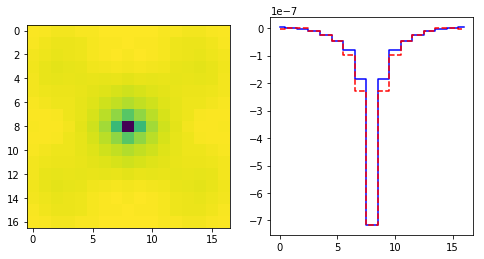

In [13]:
# And plot it
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(bf_kernel.kernel['C13'])
plt.subplot(1,2,2)
plt.plot(bf_kernel.kernel['C13'][:,8], color='blue', drawstyle='steps-mid')
plt.plot(bf_kernel.kernel['C13'][8,:], linestyle='--', color='red', drawstyle='steps-mid')
plt.show()